In [133]:

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import sys


In [134]:
# input image dimensions
img_rows, img_cols = 28, 28

In [135]:
batch_size = 128
num_classes = 10
epochs = 50


In [136]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [137]:
x_train.shape

(60000, 28, 28)

In [138]:
iterations = np.ceil((x_train.shape[0]*epochs)/batch_size)

iterations_per_epoch = np.ceil((x_train.shape[0])/batch_size)

num_batch = int(x_train.shape[0]/batch_size)

In [139]:
x_train = np.reshape(np.array(x_train), (60000, 784))
x_test = np.reshape(np.array(x_test), (10000, 784))
x_train = x_train / 255
x_test = x_test / 255

In [140]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [141]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [142]:
# Function to create individual model
def k_model(output_dim,input_dim):
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim)) 
    model.add(Activation('softmax'))
    return model

# def k_model(output_dim,input_dim):
#     model = Sequential() 
#     model.add(Dense(1000, input_dim=input_dim))
#     model.add(Activation('relu'))
#     model.add(Dense(output_dim))
#     model.add(Activation('softmax'))
#     return model

In [143]:
# Function to show the loss plot of training and validation set
def loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Baseline model 
Got one layer that maps input to 10 classes

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 1.2768 - acc: 0.6982 - val_loss: 0.8028 - val_acc: 0.8358
Epoch 2/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.7123 - acc: 0.8398 - val_loss: 0.6044 - val_acc: 0.8652
Epoch 3/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.5856 - acc: 0.8593 - val_loss: 0.5245 - val_acc: 0.8758
Epoch 4/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.5248 - acc: 0.8683 - val_loss: 0.4797 - val_acc: 0.8822
Epoch 5/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.4876 - acc: 0.8752 - val_loss: 0.4502 - val_acc: 0.8859
Epoch 6/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.4619 - acc: 0.8800 - val_loss: 0.4293 - val_acc: 0.8905
Epoch 7/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.4430 - acc: 0.8833 - val_loss: 0.4132 - val_acc

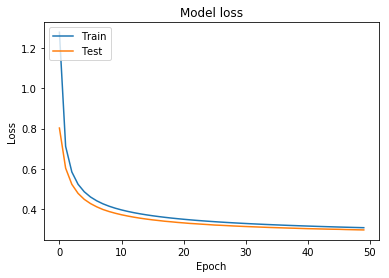

In [144]:
base_model=k_model(10,784)
lr = [0.01,0.05, 0.1, 0.001 , 0.005]
lr = [0.001]
batch_size = [16,32,64,128]
for i in lr :
    base_model=k_model(10,784)
    base_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, nesterov=False),
                  metrics=['accuracy'])
    
 
    base_model = base_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
        
    loss(base_model)

## The baseline model gives an accuracy of 91.36% at the end of 50 epochs

In [15]:
base_model.evaluate(x_train, y_train)

60000/60000 [==============================] - 2s 30us/step


[2.3025851249694824, 0.09871666666666666]

### Local SGD

Below is the list of variables:
1. Number of nodes
2. Learning rate
3. Time step
4. Data - Distributed/Not distributed

In [146]:
def list_model(n):
    l = []
    for i in range(n):
         l.append(k_model(10,784))
    
    return l

In [147]:
def define_model(n,alpha):
    models = list_model(n)
    

    num_batch = len(y_train) // batch_size

    #        c.append(0)
    #        loss.append([])

    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False, clipvalue=0.5),
                    metrics=['accuracy'])
    
    return models

In [148]:
def local_sgd(model,n,t,alpha,epoch,batch_size,train_data,test_data): 
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(model)
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
        
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        weights = []
        c_prev = c
        
        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (c_prev <= c):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    c += 1
                    c= c % num_batch

            # Obtaining the weights from each model
            for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

            new_weight = weights[0]
            
            # Averaging the weights and assigning it to each model on the nodes
            for l in range(1,n):
                if l !=n-1:
                    new_layer=[j+k for j,k in zip(new_weight,weights[l])]
                else:
                    new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
            for l in range(len(models)):
                models[l].set_weights(new_weight)


        # Evalutaing the losses (train and test and appending it to the list)
        loss_tr = models[0].evaluate(train_data[0],train_data[1])
        loss_te = models[0].evaluate(test_data[0],test_data[1])
        print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
        train_loss.append(loss_tr[0])
        test_loss.append(loss_te[0])
    
    return (train_loss,test_loss)

### The below 4 cells runs the local SGD model for 2,4,8,16 number of nodes and tunes the learning rate by taking 4 different values for each

In [151]:

model_parallel = k_model(10,784)
local_2_10_001 = local_sgd(model_parallel,2,10,0.001,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_01 = local_sgd(model_parallel,2,10,0.01,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_05 = local_sgd(model_parallel,2,10,0.05,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_1 = local_sgd(model_parallel,2,10,0.1,100,128,(x_train,y_train),(x_test,y_test))



10000/10000 [==============================] - 0s 40us/step
Epoch 0 of 100 : train loss - 2.4377848547617593 : train accuracy - 0.07361666666666666 test loss - 2.4406847816467283 test accuracy - 0.0739
10000/10000 [==============================] - 0s 39us/step
Epoch 1 of 100 : train loss - 2.4082775674184163 : train accuracy - 0.08315 test loss - 2.410748317718506 test accuracy - 0.0843
10000/10000 [==============================] - 0s 40us/step
Epoch 2 of 100 : train loss - 2.380045015335083 : train accuracy - 0.09315 test loss - 2.3820988983154296 test accuracy - 0.0964
10000/10000 [==============================] - 0s 41us/step
Epoch 3 of 100 : train loss - 2.3526986428578693 : train accuracy - 0.10501666666666666 test loss - 2.3543190658569335 test accuracy - 0.11
10000/10000 [==============================] - 0s 40us/step
Epoch 4 of 100 : train loss - 2.3270480636596678 : train accuracy - 0.11985 test loss - 2.328299334716797 test accuracy - 0.1233
10000/10000 [==================

In [152]:
model_parallel = k_model(10,784)
local_4_10_001 = local_sgd(model_parallel,4,10,0.001,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_01 = local_sgd(model_parallel,4,10,0.01,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_05 = local_sgd(model_parallel,4,10,0.05,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_1 = local_sgd(model_parallel,4,10,0.1,100,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 0s 43us/step
Epoch 0 of 100 : train loss - 2.402572696050008 : train accuracy - 0.06638333333333334 test loss - 2.406269108963013 test accuracy - 0.0673
10000/10000 [==============================] - 0s 44us/step
Epoch 1 of 100 : train loss - 2.352301762898763 : train accuracy - 0.08235 test loss - 2.355201768875122 test accuracy - 0.0812
10000/10000 [==============================] - 0s 45us/step
Epoch 2 of 100 : train loss - 2.305209436416626 : train accuracy - 0.10231666666666667 test loss - 2.3073093994140623 test accuracy - 0.1009
10000/10000 [==============================] - 0s 45us/step
Epoch 3 of 100 : train loss - 2.260190133158366 : train accuracy - 0.12611666666666665 test loss - 2.2614415473937988 test accuracy - 0.1271
10000/10000 [==============================] - 0s 43us/step
Epoch 4 of 100 : train loss - 2.217314471435547 : train accuracy - 0.15581666666666666 test loss - 2.2179364429473876 test accuracy - 0.1588
10000/100

In [153]:
model_parallel = k_model(10,784)
local_8_10_001 = local_sgd(model_parallel,8,10,0.001,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_01 = local_sgd(model_parallel,8,10,0.01,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_05 = local_sgd(model_parallel,8,10,0.05,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_1 = local_sgd(model_parallel,8,10,0.1,100,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 0s 44us/step
Epoch 0 of 100 : train loss - 2.268860121281942 : train accuracy - 0.15141666666666667 test loss - 2.264668019104004 test accuracy - 0.1537
10000/10000 [==============================] - 0s 43us/step
Epoch 1 of 100 : train loss - 2.182898319498698 : train accuracy - 0.22018333333333334 test loss - 2.1765444297790526 test accuracy - 0.2215
10000/10000 [==============================] - 0s 44us/step
Epoch 2 of 100 : train loss - 2.106727732022603 : train accuracy - 0.28373333333333334 test loss - 2.0988365924835204 test accuracy - 0.2884
10000/10000 [==============================] - 0s 44us/step
Epoch 3 of 100 : train loss - 2.0354398921966554 : train accuracy - 0.3403333333333333 test loss - 2.0259734703063965 test accuracy - 0.3482
10000/10000 [==============================] - 0s 44us/step
Epoch 4 of 100 : train loss - 1.9696124450047812 : train accuracy - 0.39405 test loss - 1.9589424884796143 test accuracy - 0.4037
10000/1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 1s 50us/step
Epoch 50 of 100 : train loss - 0.29677944443722565 : train accuracy - 0.91725 test loss - 0.29057698745429517 test accuracy - 0.9192
10000/10000 [==============================] - 1s 50us/step
Epoch 51 of 100 : train loss - 0.29646814097464086 : train accuracy - 0.9163833333333333 test loss - 0.2888468283981085 test accuracy - 0.9195
10000/10000 [==============================] - 1s 51us/step
Epoch 52 of 100 : train loss - 0.29527695304056006 : train accuracy - 0.9179333333333334 test loss - 0.28796351856291297 test accuracy - 0.9194
10000/10000 [==============================] - 1s 52us/step
Epoch 53 of 100 : train loss - 0.29505817030370235 : train accuracy - 0.9175 test loss - 0.2880439664691687 test accuracy - 0.9194
10000/10000 [==============================] - 1s 51us/step
Epoch 54 of 100 : train loss - 0.2941345455944538 : train accuracy - 0.9179166666666667 test loss - 0.2869909630149603 test accuracy - 0.9204
10000/1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
model_parallel = k_model(10,784)
local_16_10_001 = local_sgd(model_parallel,16,10,0.001,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_01 = local_sgd(model_parallel,16,10,0.01,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_05 = local_sgd(model_parallel,16,10,0.05,100,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_1 = local_sgd(model_parallel,16,10,0.1,100,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 0s 49us/step
Epoch 0 of 100 : train loss - 2.233050952275594 : train accuracy - 0.18303333333333333 test loss - 2.21202381439209 test accuracy - 0.1952
10000/10000 [==============================] - 0s 48us/step
Epoch 1 of 100 : train loss - 2.075713046646118 : train accuracy - 0.28005 test loss - 2.0530135036468504 test accuracy - 0.2957
10000/10000 [==============================] - 0s 50us/step
Epoch 2 of 100 : train loss - 1.9400315242767334 : train accuracy - 0.38743333333333335 test loss - 1.9160978136062623 test accuracy - 0.4036
10000/10000 [==============================] - 0s 50us/step
Epoch 3 of 100 : train loss - 1.8194743356704712 : train accuracy - 0.5082333333333333 test loss - 1.7942036083221435 test accuracy - 0.5238
10000/10000 [==============================] - 1s 52us/step
Epoch 4 of 100 : train loss - 1.7132234563191733 : train accuracy - 0.5956166666666667 test loss - 1.687054974746704 test accuracy - 0.6161
10000/100

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 1s 51us/step
Epoch 64 of 100 : train loss - 0.34744327334165576 : train accuracy - 0.9033833333333333 test loss - 0.33135608844161035 test accuracy - 0.91
10000/10000 [==============================] - 0s 49us/step
Epoch 65 of 100 : train loss - 0.34650264229774475 : train accuracy - 0.9037 test loss - 0.33076227036714556 test accuracy - 0.9095
10000/10000 [==============================] - 1s 51us/step
Epoch 66 of 100 : train loss - 0.3456113270401955 : train accuracy - 0.9037666666666667 test loss - 0.3298884788990021 test accuracy - 0.9089
10000/10000 [==============================] - 1s 51us/step
Epoch 67 of 100 : train loss - 0.34502658699949584 : train accuracy - 0.9044333333333333 test loss - 0.32927194904088974 test accuracy - 0.9099
10000/10000 [==============================] - 1s 51us/step
Epoch 68 of 100 : train loss - 0.3440439114689827 : train accuracy - 0.9040333333333334 test loss - 0.3283132379770279 test accuracy - 0.910

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 1s 54us/step
Epoch 24 of 100 : train loss - 0.2939516141305367 : train accuracy - 0.9174333333333333 test loss - 0.2898963483631611 test accuracy - 0.9175
10000/10000 [==============================] - 1s 54us/step
Epoch 25 of 100 : train loss - 0.2920052087247372 : train accuracy - 0.9185 test loss - 0.28942039892673493 test accuracy - 0.9195
10000/10000 [==============================] - 1s 54us/step
Epoch 26 of 100 : train loss - 0.29148313448826474 : train accuracy - 0.9186666666666666 test loss - 0.2876826862245798 test accuracy - 0.92
10000/10000 [==============================] - 1s 53us/step
Epoch 27 of 100 : train loss - 0.29062761652867 : train accuracy - 0.9186 test loss - 0.2876567016988993 test accuracy - 0.9202
10000/10000 [==============================] - 1s 55us/step
Epoch 28 of 100 : train loss - 0.2885277338445187 : train accuracy - 0.9193333333333333 test loss - 0.28512338645458224 test accuracy - 0.9205
10000/10000 [==

In [159]:
# Function to show the loss plot of training and validation set
def combined_loss(losses,description):
    for i in losses :
        plt.plot(i[0])
        plt.title('Train loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()
    
    for i in losses :
        plt.plot(i[1])
        plt.title('Test loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()

### Train test loss for node = 2

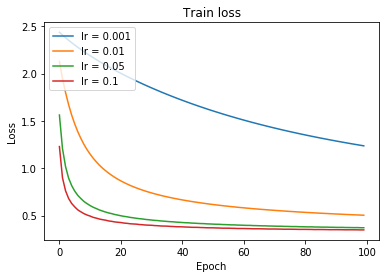

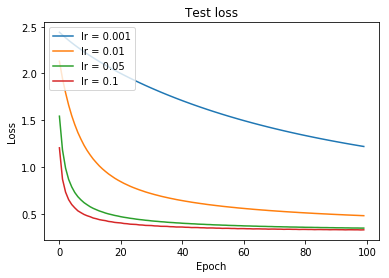

In [160]:
losses_2 = [local_2_10_001,local_2_10_01,local_2_10_05,local_2_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for node = 4

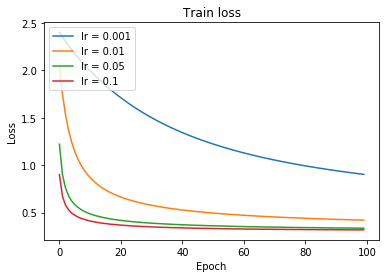

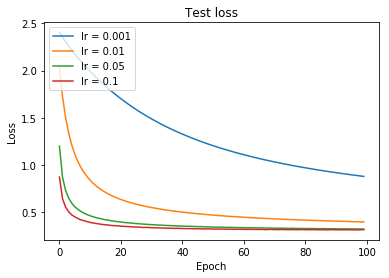

In [161]:
losses_2 = [local_4_10_001,local_4_10_01,local_4_10_05,local_4_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train Test loss for nodes = 8

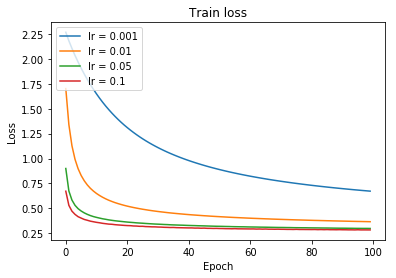

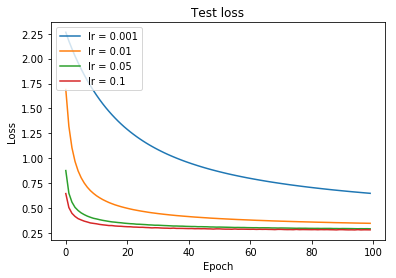

In [162]:
losses_2 = [local_8_10_001,local_8_10_01,local_8_10_05,local_8_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for nodes = 16

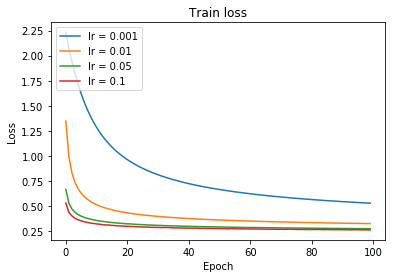

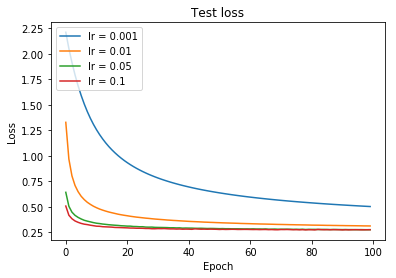

In [163]:
losses_2 = [local_16_10_001,local_16_10_01,local_16_10_05,local_16_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for lr = 0.01 and nodes = 2,4,8,16

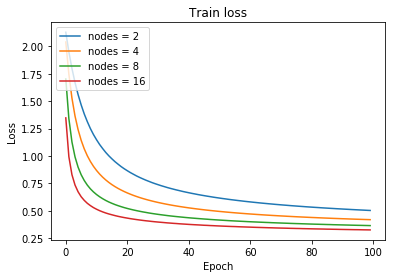

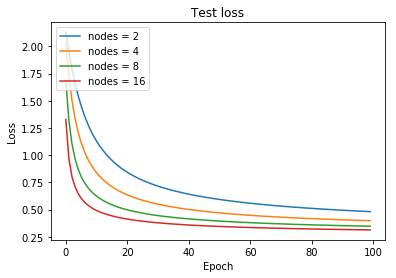

In [164]:
losses_2 = [local_2_10_01,local_4_10_01,local_8_10_01,local_16_10_01]
desc = ['nodes = 2','nodes = 4','nodes = 8','nodes = 16']
combined_loss(losses_2,desc)